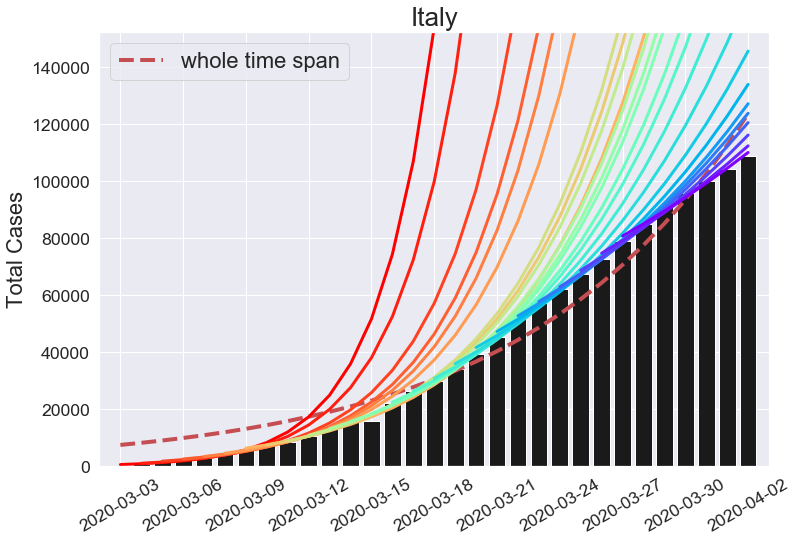

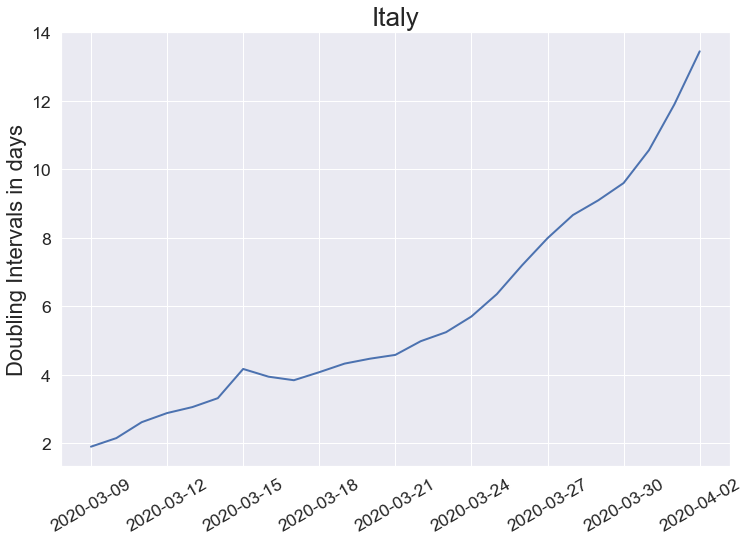

In [8]:
from datetime import datetime
import pandas as pd
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm, rcParams
from scipy.optimize import curve_fit
import seaborn as sns

rcParams['figure.figsize'] = (12,8)
sns.set()
sns.set_context("notebook",font_scale=1.6)
plt.close('all')

def fit_expo(x,y):
    # y = a *exp(b*x)
    
    # find linearized solution as starting point
    # log(y) = log(a) + b*x = [1 x].T @ [log(a) b]
    # the log puts emphasize on small numbers, make weighting
    logy = np.log(y)
    logy[np.isneginf(logy)] = 0
    
    logParams   = np.polyfit(x, logy, 1,w=np.sqrt(y))
    initParams  = (np.exp(logParams[1]), logParams[0])
    params      = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, p0=initParams)
    return params[0],params[1],initParams


date        = '2020-04-02'

url         = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-"
url         = url +date+".xlsx"

df          = pd.read_excel(url)
#df.head() #show table

country     = 'Italy' #e.g. South Korea,China, United_States_of_America,United_Kingdom, Italy, Austria
df_filtered = df[df['countriesAndTerritories'] == country]  

#df_filtered['Cases'].describe()  # describtive statistics

timeSpan    = 31  # last month
dates       = np.array(df_filtered['dateRep'][0:timeSpan],dtype='datetime64[D]')
dates       = dates[::-1]
newCases    = np.array(df_filtered['cases'])[0:timeSpan] 
newCases    = newCases[::-1]  #reverse order 
allCases    = np.cumsum(newCases)
xTicks      = np.arange(np.size(newCases))

######## fit over whole time span   ##########
plt.figure(1)
params,_, _ = fit_expo(xTicks,allCases)
plt.plot(xTicks, params[0]*np.exp(params[1]*xTicks),'r--', linewidth = 4, label = 'whole time span')

######## sliding fit ###########
fittedDays   = 7
n            = timeSpan-fittedDays+1  #samples for sliding fit

colorMap     = cm.rainbow(np.linspace(1,0,n)) #e.g. rainbow, magma
color        = iter(colorMap)   
doublingVec  = np.zeros((n,))

for d in range(n):   
    c=next(color)
    y = allCases[d:d+fittedDays]
    x = xTicks[d:d+fittedDays]
    params,_, _ = fit_expo(x,y) 
    yFit    = params[0]*np.exp(params[1]*xTicks)
    plt.plot(xTicks[d::], yFit[d::] , c=c, linewidth = '3')    
    doublingVec[d]   = np.log(2)/params[1]
    
plt.bar(xTicks,allCases,color = 'k', alpha=1  , align = 'center')    
plt.ylim([0,allCases[-1]*1.4])   
plt.xlim([-1, timeSpan]) 
plt.grid(True)
plt.ylabel('Total Cases', fontsize = 22)
plt.title(country.replace('_',' '), fontsize = 26)
plt.xticks(xTicks[::3], dates[::3], rotation=30)
plt.legend(loc = 2, fontsize = 22)
plt.show()


plt.figure(2)
plt.plot(xTicks[fittedDays-1::], doublingVec, linewidth = '2')
plt.xticks(xTicks[fittedDays-1::3], dates[fittedDays-1::3], rotation=30)
plt.ylabel('Doubling Intervals in days', fontsize = 22)
plt.title(country.replace('_',' '), fontsize = 26)
plt.grid(True)
plt.show()